In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers

2022-04-04 21:49:47.362377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 21:49:47.362444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [93]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")
# df = df[df["rt_plant_id"].isin([672, 968, 969])]
# df = df[df["rt_plant_id"].isin([672, 968])]

In [94]:
GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

PLANTS = sorted(df.rt_plant_id.unique())

def expand_plant_dimension(df):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_time, n_loc, n_cols))
    for i, plant_id in enumerate(PLANTS):
        df_np[:, i, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

train_df_np = expand_plant_dimension(train_df)
valid_df_np = expand_plant_dimension(valid_df)
test_df_np = expand_plant_dimension(test_df)


In [95]:
scalers = {}
for i, plant in enumerate(PLANTS):
    scalers[plant] = MinMaxScaler()
    # train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
    train_df_np[:, i, :] = scalers[plant].fit_transform(train_df_np[:, i, :])
    valid_df_np[:, i, :] = scalers[plant].transform(valid_df_np[:, i, :])
    test_df_np[:, i, :] = scalers[plant].transform(test_df_np[:, i, :])
    
train_df_np = np.array(train_df_np, dtype=np.float32)
valid_df_np = np.array(valid_df_np, dtype=np.float32)
test_df_np = np.array(test_df_np, dtype=np.float32)


In [96]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, valid_df=valid_df, test_df=test_df,
                 columns=None, label_columns=None):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.ndim = self.train_df.ndim
        assert self.ndim in [2, 3]
        if columns is None:
            columns = train_df.columns

        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(columns)}
        self.feature_column_indices = [v for k,v in self.column_indices.items() if k not in self.label_columns]
        # self.feature_number = len(self.feature_column_indices)
        if self.train_df.ndim == 2:
            self.number_of_plants = 1
        else:
            self.number_of_plants = self.train_df.shape[1]
        # list(self.label_columns_indices.values())

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.input_shape = (self.input_width, self.number_of_plants, len(self.feature_column_indices))

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :, 1:]
        labels = features[:, self.labels_slice, :, :]
        labels = tf.stack([labels[:, :, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None, None])
        labels.set_shape([None, self.label_width, None, None])
        return inputs, labels

    def plot(self, model=None, plot_col='production', plant=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            if plant is not None:
                input_values = inputs[n, :, plant, plot_col_index]
                label_values = labels[n, :, plant, label_col_index]
            else:
                input_values = tf.math.reduce_mean(inputs[n, :, :, plot_col_index], axis=1)
                label_values = tf.math.reduce_mean(labels[n, :, :, label_col_index], axis=1)
                
            plt.plot(self.input_indices, input_values, label='Inputs', marker='.', zorder=-10)

            plt.scatter(self.label_indices, label_values, edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if plant is not None:
                    prediction_values = predictions[n, :, plant, label_col_index]
                else:
                    prediction_values = tf.math.reduce_mean(predictions[n, :, :, label_col_index], axis=1)
                
                prediction_values = tf.clip_by_value(prediction_values, clip_value_min=0, clip_value_max=1)

                plt.scatter(self.label_indices, prediction_values, marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            # sequence_stride=24, shuffle=False,
            sequence_stride=1, shuffle=True,
            batch_size=64,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [97]:
def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [98]:
OUT_STEPS = 24

columns = [col for col in train_df.columns if col != "rt_plant_id"]

multi_window = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,
    input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['production']

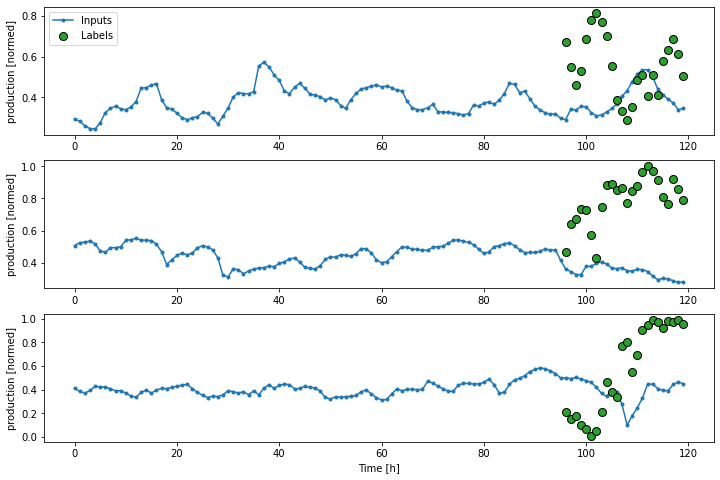

In [99]:
multi_window.plot(plant=0)

In [100]:
multi_val_performance = {}
multi_performance = {}

## Dense

### Linear

In [79]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,3,1)))
model.add(layers.Dense(32, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dense(16))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_6 (Permute)         (None, 2, 16, 120)        0         
                                                                 
 dense_25 (Dense)            (None, 2, 16, 32)         3872      
                                                                 
 dense_26 (Dense)            (None, 2, 16, 16)         528       
                                                                 
 reshape_26 (Reshape)        (None, 2, 256)            0         
                                                                 
 dense_27 (Dense)            (None, 2, 24)             6168      
                                                                 
 permute_7 (Permute)         (None, 24, 2)             0         
                                                                 
 reshape_27 (Reshape)        (None, 24, 2, 1)        

In [80]:
history = compile_and_fit(model, multi_window)

Epoch 1/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0639 - mean_absolute_error: 0.1965 - wmape: 0.5494 - val_loss: 0.0556 - val_mean_absolute_error: 0.1896 - val_wmape: 0.4464
Epoch 2/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0449 - mean_absolute_error: 0.1602 - wmape: 0.4483 - val_loss: 0.0519 - val_mean_absolute_error: 0.1725 - val_wmape: 0.4060
Epoch 3/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0427 - mean_absolute_error: 0.1557 - wmape: 0.4345 - val_loss: 0.0490 - val_mean_absolute_error: 0.1745 - val_wmape: 0.4111
Epoch 4/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0419 - mean_absolute_error: 0.1545 - wmape: 0.4318 - val_loss: 0.0481 - val_mean_absolute_error: 0.1686 - val_wmape: 0.3959
Epoch 5/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0409 - mean_absolute_error: 0.1527 - wmape: 0.4265 - val_loss: 0.0468 - val_mean_absolute_error: 0.1666 - val_wmape: 0.

40/40 [==============================] - 0s 1ms/step - loss: 0.0569 - mean_absolute_error: 0.1783 - wmape: 0.3654


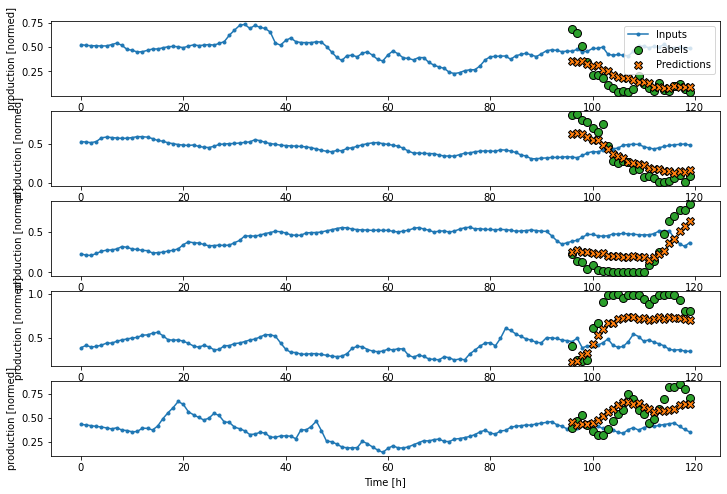

In [81]:
multi_val_performance['Linear'] = model.evaluate(multi_window.valid)
multi_performance['Linear'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0, max_subplots=5)

### Linear2

In [101]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dropout(0.2))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_20 (Permute)        (None, 94, 120, 16)       0         
                                                                 
 dense_39 (Dense)            (None, 94, 120, 24)       408       
                                                                 
 dropout_6 (Dropout)         (None, 94, 120, 24)       0         
                                                                 
 reshape_35 (Reshape)        (None, 94, 2880)          0         
                                                                 
 dense_40 (Dense)            (None, 94, 24)            69144     
                                                                 
 permute_21 (Permute)        (None, 24, 94)            0         
                                                                 
 reshape_36 (Reshape)        (None, 24, 94, 1)       

In [102]:
history = compile_and_fit(model, multi_window)

Epoch 1/100
329/329 [==============================] - 45s 135ms/step - loss: 0.0656 - mean_absolute_error: 0.1985 - wmape: 0.5683 - val_loss: 0.0528 - val_mean_absolute_error: 0.1776 - val_wmape: 0.4235
Epoch 2/100
329/329 [==============================] - 45s 135ms/step - loss: 0.0533 - mean_absolute_error: 0.1760 - wmape: 0.5031 - val_loss: 0.0509 - val_mean_absolute_error: 0.1750 - val_wmape: 0.4162
Epoch 3/100
329/329 [==============================] - 45s 135ms/step - loss: 0.0527 - mean_absolute_error: 0.1752 - wmape: 0.5005 - val_loss: 0.0505 - val_mean_absolute_error: 0.1810 - val_wmape: 0.4314
Epoch 4/100
329/329 [==============================] - 45s 135ms/step - loss: 0.0521 - mean_absolute_error: 0.1741 - wmape: 0.4975 - val_loss: 0.0494 - val_mean_absolute_error: 0.1772 - val_wmape: 0.4218
Epoch 5/100
329/329 [==============================] - 45s 136ms/step - loss: 0.0520 - mean_absolute_error: 0.1740 - wmape: 0.4970 - val_loss: 0.0499 - val_mean_absolute_error: 0.1791 

40/40 [==============================] - 2s 41ms/step - loss: 0.0698 - mean_absolute_error: 0.1979 - wmape: 0.4719


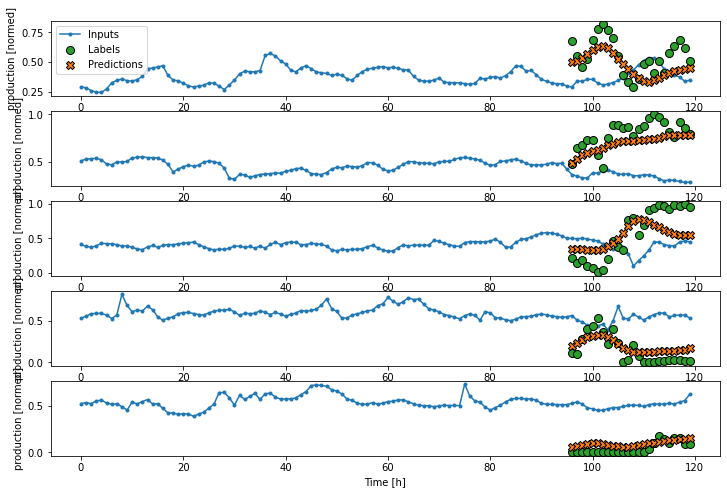

In [103]:
multi_val_performance['Linear'] = model.evaluate(multi_window.valid)
multi_performance['Linear'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0, max_subplots=5)

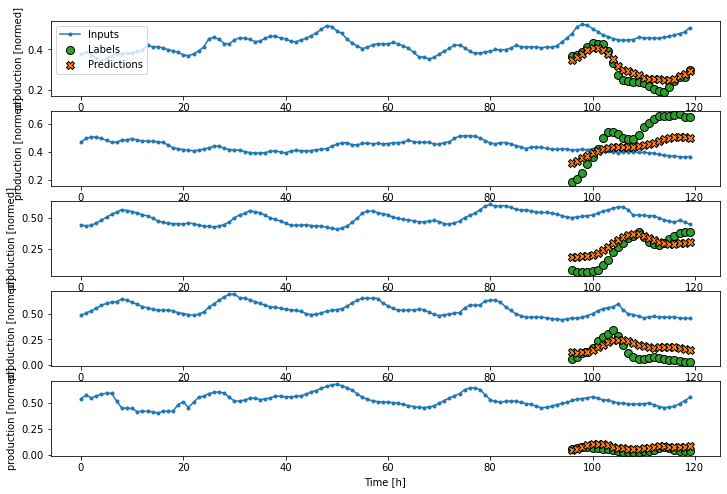

In [104]:
multi_window.plot(model, max_subplots=5)

### Conv4

In [116]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [134]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))
model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_109 (Permute)       (None, 94, 120, 16)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 94, 120, 64)       25664     
                                                                 
 permute_110 (Permute)       (None, 120, 64, 94)       0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 60, 32, 94)       0         
 g2D)                                                            
                                                                 
 permute_111 (Permute)       (None, 94, 60, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 94, 60, 32)        25632     
                                                     

In [ ]:
history = compile_and_fit(model, multi_window)

Epoch 1/40
101/329 [========>.....................] - ETA: 4:15 - loss: 0.0875 - mean_absolute_error: 0.2361 - wmape: 0.6827